<a href="https://colab.research.google.com/github/arghya53/TimeSeriesAnalysis/blob/main/Time_Series_Using_Prophet_MultiVariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multiivariate time series modeling. We are going to model electricity demand with respect to a time frame between 2012-2017 of the city of new-york. In the previous univariate analysis we analysed change of demand with time. Now we will analyse change of both demand and temperature with respect to timestamp.

In [ ]:
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
import datetime

mpl.rcParams['figure.figsize']= (10,8)
mpl.rcParams['axes.grid']=False

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv")
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [ ]:
df['timeStamp']=pd.to_datetime(df['timeStamp'])

In [ ]:
import plotly.express as px

fig = px.line(df, x='timeStamp', y='demand', title= 'NYC Energy Demand')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label='1y', step='year', stepmode='backward'),
            dict(count=2, label='3y', step='year', stepmode='backward'),
            dict(count=3, label='5y', step='year', stepmode='backward'),
            dict(step='all')
        ])
    )
)
fig.show()

In [ ]:
ny_df = df.set_index('timeStamp')

array([<Axes: xlabel='timeStamp'>, <Axes: xlabel='timeStamp'>,
       <Axes: xlabel='timeStamp'>], dtype=object)

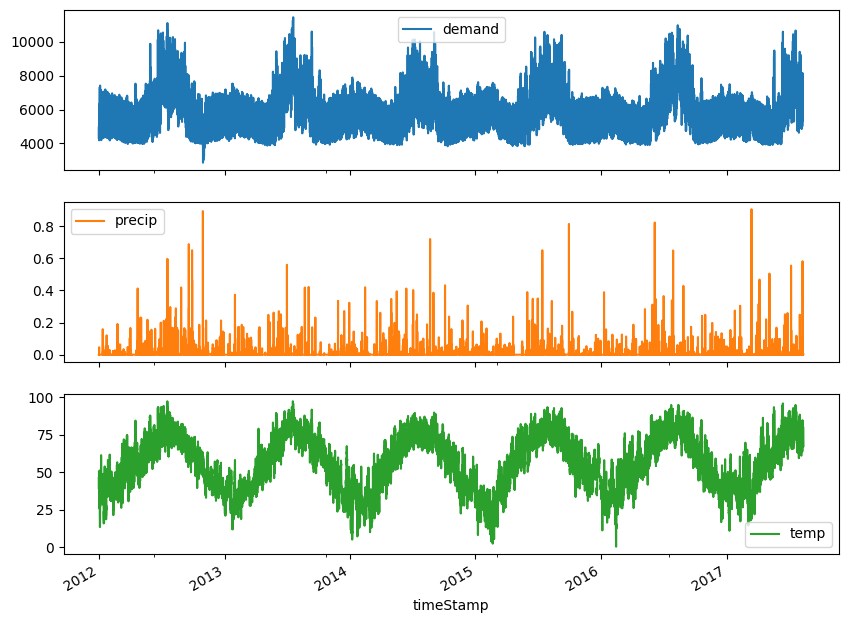

In [ ]:
ny_df.plot(subplots=True)

array([<Axes: xlabel='timeStamp'>, <Axes: xlabel='timeStamp'>,
       <Axes: xlabel='timeStamp'>], dtype=object)

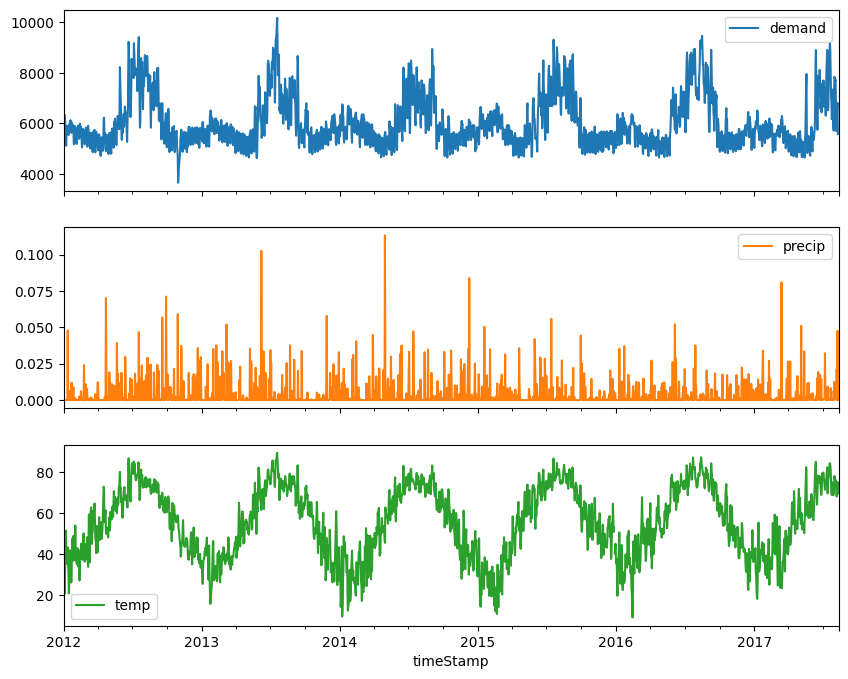

In [ ]:
ny_df_daily = ny_df.resample('D').mean()
ny_df_daily.plot(subplots=True)

the forecast we are going to predict

---

y(t) = g(t){trend component}+s(t){seasonality}+h(t){holiday}+e(t){residual/error component}

---

Here trend component is 0. So multiplicative modeling is not used.

In [ ]:
!pip install prophet

In [ ]:
ny_df_daily

,demand,precip,temp
timeStamp,,,
2012-01-01,4954.833333,0.002487,46.510000
2012-01-02,5302.954167,0.000000,40.496667
2012-01-03,6095.512500,0.000000,26.672500
2012-01-04,6336.266667,0.000000,20.585000
2012-01-05,6130.245833,0.000000,33.577500
...,...,...,...
2017-08-08,6471.626042,0.000000,71.039167
2017-08-09,6811.112167,0.047529,73.852500
2017-08-10,5582.297000,0.002033,75.217500


In [ ]:
ny_df_final= ny_df_daily.reset_index()[['timeStamp', 'demand', 'temp']].rename({'timeStamp':'ds', 'demand': 'y', 'temp':'temp'}, axis='columns')

In [ ]:
ny_df_final

,ds,y,temp
0,2012-01-01,4954.833333,46.510000
1,2012-01-02,5302.954167,40.496667
2,2012-01-03,6095.512500,26.672500
3,2012-01-04,6336.266667,20.585000
4,2012-01-05,6130.245833,33.577500
...,...,...,...
2046,2017-08-08,6471.626042,71.039167
2047,2017-08-09,6811.112167,73.852500
2048,2017-08-10,5582.297000,75.217500
2049,2017-08-11,NaN,72.767917


In [ ]:
from prophet import Prophet

In [ ]:
ny_df_final.query('temp != temp') # searching missing values

,ds,y,temp
1457,2015-12-28,5510.776333,NaN


In [ ]:
ny_df_final['temp']=ny_df_final['temp'].fillna(method = 'ffill') # imputation

In [ ]:
ny_df_final.query('temp != temp')

,ds,y,temp


Previous model fil with Univariae analysis (black points- actual value, dark blue- predicted value, light blue- confidence interval)

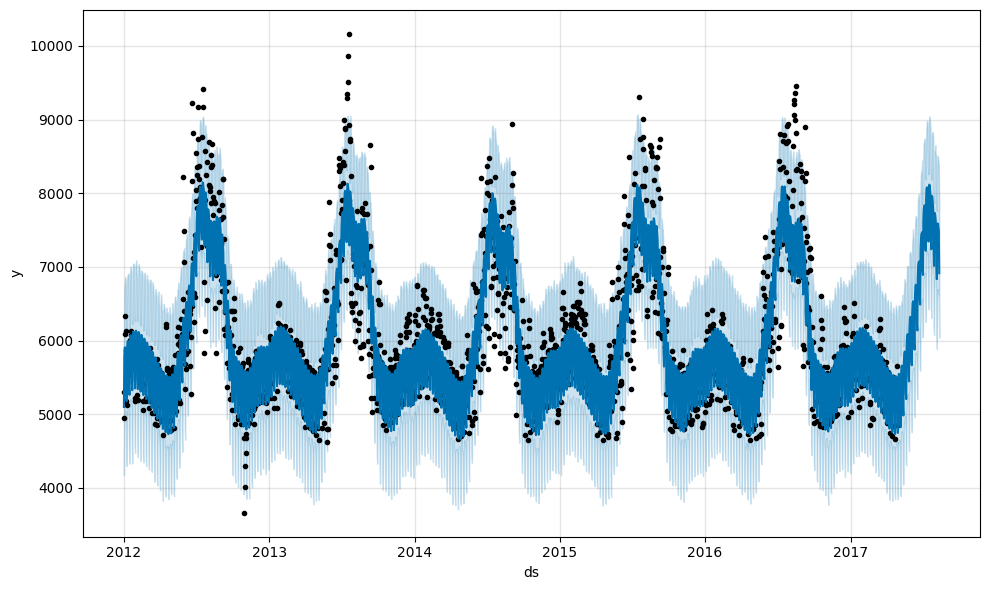

As the previous one was based only on univariate (demand) data, so now we are going to train the model with temp data

In [ ]:
ny_df_final['month'] = ny_df_final['ds'].dt.month # dt.month is extracting the datetime component from datetime column

In [ ]:
ny_df_final.head()

,ds,y,temp,month
0,2012-01-01,4954.833333,46.510000,1
1,2012-01-02,5302.954167,40.496667,1
2,2012-01-03,6095.512500,26.672500,1
3,2012-01-04,6336.266667,20.585000,1
4,2012-01-05,6130.245833,33.577500,1


In [ ]:
fig = px.line(ny_df_final, x='ds', y='y', hover_data = ['temp', 'month'], title='NYC Energy Demand')

fig.update_xaxes(
    rangeslider_visible= True,
    rangeselector = dict(
        buttons = list([
            dict(count=1, label='1y', step='year', stepmode='backward'),
            dict(count=2, label='3y', step='year', stepmode='backward'),
            dict(count=3, label='5y', step='year', stepmode='backward'),
            dict(step='all')
            ])
)
)

It is seen that when the temperature is preety high our model can't predict the outliers properly. The reason may be that, mean is preety far w.r.t. the min and max values, so the predictor may take those points as anomalous although it is not. So, now we are going to view the max, min, and mean temperature of each month.

In [ ]:
ny_df_final[['month', 'temp']].groupby('month').agg({'temp':{'max', 'min', 'mean'}})

temp                      
             max       mean        min
month                                 
1      55.420455  33.432140   9.507917
2      59.360000  34.517758   9.015000
3      67.878333  41.419884  20.291667
4      72.992083  52.600204  33.045833
5      82.576250  62.543994  48.090833
6      86.916667  71.334418  52.405833
7      89.606667  77.595627  66.417083
8      87.426250  75.525947  68.042083
9      84.448750  69.550306  57.274583
10     74.277500  58.642895  42.106250
11     67.606250  47.225638  27.172500
12     64.735000  41.520068  22.429583

In [ ]:
# checking correlation between temperature and demand

ny_df_final[['y', 'temp']].corr() # it's not a strong correltation

,y,temp
y,1.000000,0.560888
temp,0.560888,1.000000


In [ ]:
ny_df_final.query('temp > 80')[['y', 'temp']].corr()

,y,temp
y,1.000000,0.552918
temp,0.552918,1.000000


In [ ]:
ny_df_final.query('temp < 80')[['y', 'temp']].corr()

,y,temp
y,1.000000,0.470562
temp,0.470562,1.000000


In [ ]:
def summer_temp(temp):
  if temp > 80:
    return 1
  else:
    return 0

In [ ]:
ny_df_final['summer_temp']= ny_df_final['temp'].apply(summer_temp)

In [ ]:
ny_df_final['month_bins']= pd.cut(ny_df_final['month'], bins=3, labels=False) # 3 bins divide the data in
ny_df_final

,ds,y,temp,month,summer_temp,month_bins
0,2012-01-01,4954.833333,46.510000,1,0,0
1,2012-01-02,5302.954167,40.496667,1,0,0
2,2012-01-03,6095.512500,26.672500,1,0,0
3,2012-01-04,6336.266667,20.585000,1,0,0
4,2012-01-05,6130.245833,33.577500,1,0,0
...,...,...,...,...,...,...
2046,2017-08-08,6471.626042,71.039167,8,0,1
2047,2017-08-09,6811.112167,73.852500,8,0,1
2048,2017-08-10,5582.297000,75.217500,8,0,1
2049,2017-08-11,NaN,72.767917,8,0,1


In [ ]:
train = ny_df_final[(ny_df_final['ds']>= '2012-01-01') & (ny_df_final['ds']<= '2017-04-30')]
test = ny_df_final[(ny_df_final['ds'])>'2017-04-30']

In [ ]:
train.shape

(1947, 6)

In [ ]:
test.shape

(104, 6)

In [ ]:
test

,ds,y,temp,month,summer_temp,month_bins
1947,2017-05-01,5417.231583,60.300833,5,0,1
1948,2017-05-02,5697.950042,67.537917,5,0,1
1949,2017-05-03,5354.628500,59.413333,5,0,1
1950,2017-05-04,5235.704833,54.877083,5,0,1
1951,2017-05-05,5358.639500,55.720833,5,0,1
...,...,...,...,...,...,...
2046,2017-08-08,6471.626042,71.039167,8,0,1
2047,2017-08-09,6811.112167,73.852500,8,0,1
2048,2017-08-10,5582.297000,75.217500,8,0,1
2049,2017-08-11,NaN,72.767917,8,0,1


In [ ]:
m = Prophet(interval_width=0.95) # modeling the prophet for 95% confidence-interval

In [ ]:
m.add_regressor('summer_temp', standardize= False)
m.add_regressor('month_bins', standardize = False, mode='multiplicative')

multiplicative mode is used when we have
interaction between variables

---
in the first regressor by default additive mode is used


---


by default prophet takes only two columns. We use add_regressor for multivariate analysis

---


incorporating external factors ("summer_temp" and "month_bins") into the forecasting process.

In [ ]:
m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpix1gg_zy/_ec38pp9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpix1gg_zy/ak0bw2xo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89138', 'data', 'file=/tmp/tmpix1gg_zy/_ec38pp9.json', 'init=/tmp/tmpix1gg_zy/ak0bw2xo.json', 'output', 'file=/tmp/tmpix1gg_zy/prophet_modelmpjhnu03/prophet_model-20231025151724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:17:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:17:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
m.params

OrderedDict([('lp__', array([[5339.92]])),
             ('k', array([[0.145186]])),
             ('m', array([[0.588993]])),
             ('delta',
              array([[-6.08473e-08, -1.74291e-04, -1.84798e-01, -1.10365e-06,
                       2.80869e-08,  1.40912e-02,  8.05194e-03,  1.10844e-02,
                       3.89223e-03,  8.65245e-04, -2.12610e-08, -5.18877e-02,
                       6.31308e-09,  1.87150e-06,  1.38317e-01,  6.01324e-04,
                      -6.72531e-08, -9.52036e-02, -3.95509e-02,  2.17609e-07,
                       1.86624e-07, -1.59191e-07,  3.58926e-02,  2.53746e-02,
                       9.95629e-07]])),
             ('sigma_obs', array([[0.0388099]])),
             ('beta',
              array([[-0.0354081 , -0.0591315 ,  0.049488  ,  0.0401483 , -0.00951542,
                      -0.00176697, -0.00777387, -0.00252371,  0.00344382, -0.00585576,
                       0.00139808,  0.00306113, -0.00524141, -0.00380363,  0.00338019,
           

In [ ]:
# as we have 104 test data we create a timeStamp for 104 days
future = m.make_future_dataframe(periods=104)
future.tail()

,ds
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11
2050,2017-08-12


In [ ]:
future['summer_temp'] = ny_df_final['summer_temp']

In [ ]:
future['month_bins'] = ny_df_final['month_bins']

In [ ]:
future.tail()

,ds,summer_temp,month_bins
2046,2017-08-08,0,1
2047,2017-08-09,0,1
2048,2017-08-10,0,1
2049,2017-08-11,0,1
2050,2017-08-12,0,1


In [ ]:
# prepdicting the future data
forecast= m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2046,2017-08-08,7380.432382,6619.566917,8190.789704
2047,2017-08-09,7391.261337,6618.480574,8133.089225
2048,2017-08-10,7361.586832,6556.135962,8102.841230
2049,2017-08-11,7311.392866,6627.674746,8110.853613
2050,2017-08-12,6730.517104,5946.171289,7523.784443


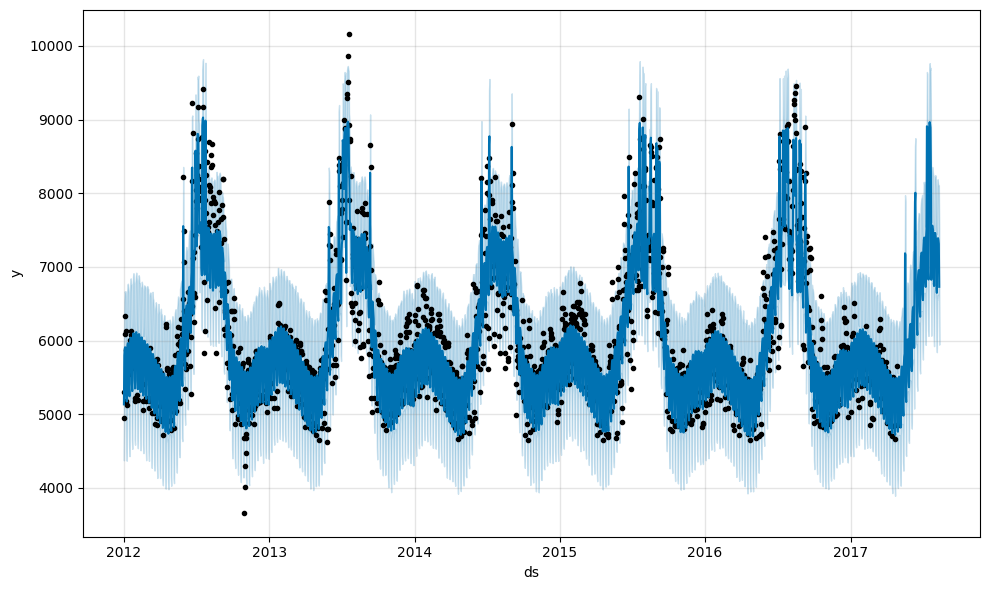

In [ ]:
fig1 = m.plot(forecast)

Here, we can see that our model is able to capture the outliers unlike the one with univariate analysis.

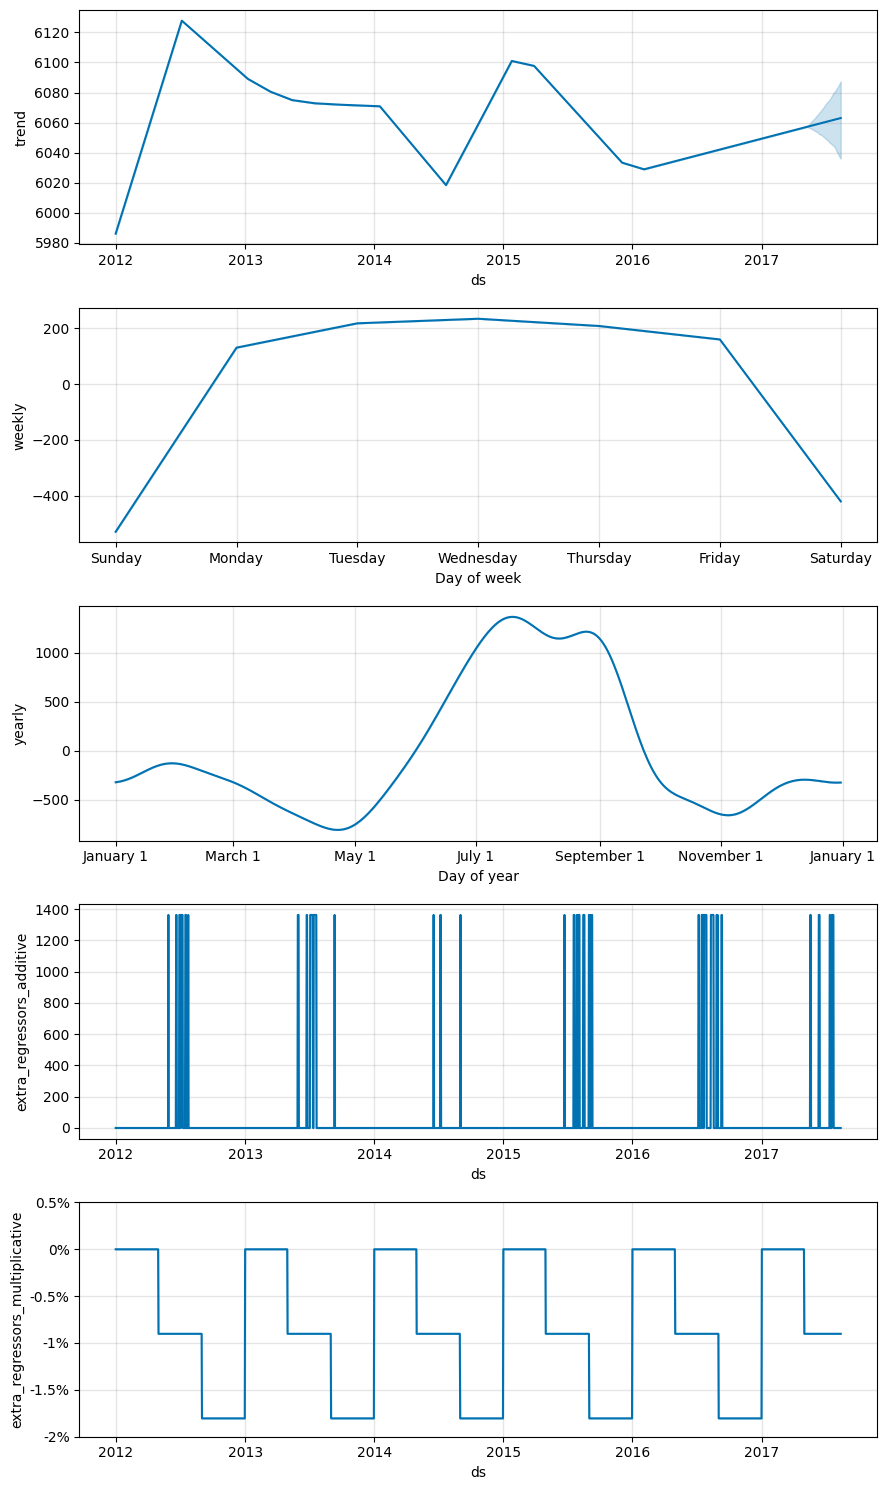

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)

In [ ]:
plot_components_plotly(m, forecast)

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(m, initial= '731 days', horizon= '365 days')
df_p = performance_metrics(df_cv)
df_p

In [ ]:
print(df_p['mape'].max() , df_p['mape'].min())
print(df_p['mae'].max() , df_p['mae'].min())
print(df_p['mdape'].max() , df_p['mdape'].min())
print(df_p['smape'].max() , df_p['smape'].min())

0.0844488559359637 0.044826776846603474
558.7448176073439 241.09492766477723
0.08311342355194973 0.037389442302098244
0.08508653205052921 0.04470346881021788


values from previous univariate analysis

0.10475179588813116       0.06142698067969529

---


704.8251925391082         328.5898752770228

---


0.10242961021125313       0.05292891328141122

---


0.10542369898962645       0.06094700168403503

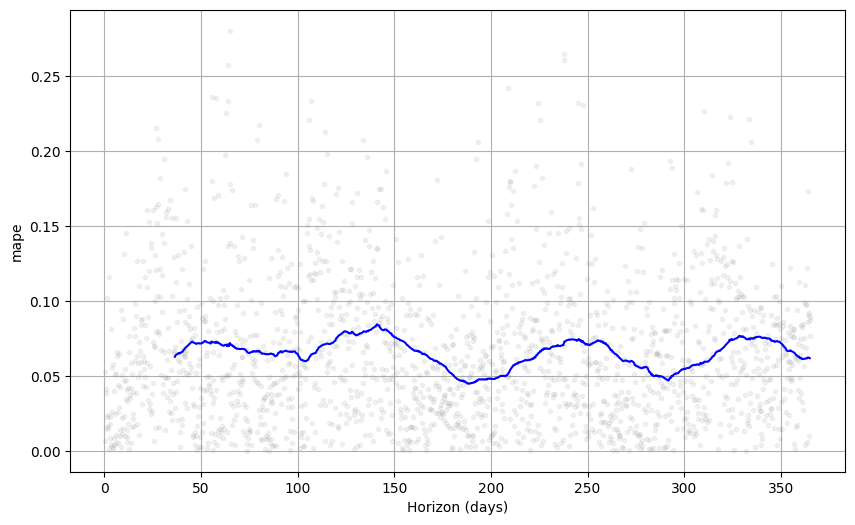

In [ ]:
from prophet.plot import plot_cross_validation_metric as pcvm
fig = pcvm(df_cv, metric='mape')